<a href="https://colab.research.google.com/github/beelittlehoney/CCRNFLRL_PROJECT_COM221ML/blob/main/%5BRL%5D2048_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install gymnasium_2048 -q
!pip install moviepy -q

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML, clear_output
import time
from gymnasium import spaces

# Adjusted 2048 Environment for Reward Shaping

In [ ]:
class Game2048Env(gym.Env):
    def __init__(self):
        super(Game2048Env, self).__init__()
        self.grid_size = 4
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Box(low=0, high=2048,
                                            shape=(self.grid_size, self.grid_size), dtype=np.int32)
        self.reset()

    def reset(self):
        self.board = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)
        self._add_tile(); self._add_tile()
        return self.board.copy()

    def _add_tile(self):
        empty = list(zip(*np.where(self.board == 0)))
        if empty:
            y, x = empty[np.random.randint(len(empty))]
            self.board[y, x] = 2 if np.random.random() < 0.9 else 4

    def _move(self, board, direction):
        # Rotate to reuse left-move logic
        for _ in range(direction):
            board = np.rot90(board)
        moved, new_board, score = self._merge(board)
        for _ in range(-direction % 4):
            new_board = np.rot90(new_board)
        return moved, new_board, score

    def _merge(self, board):
        new_board = np.zeros_like(board)
        score = 0
        moved = False
        for i in range(self.grid_size):
            tiles = board[i][board[i] != 0]
            merged = []
            skip = False
            for j in range(len(tiles)):
                if skip:
                    skip = False
                    continue
                if j + 1 < len(tiles) and tiles[j] == tiles[j + 1]:
                    merged.append(tiles[j] * 2)
                    score += tiles[j] * 2
                    skip = True
                else:
                    merged.append(tiles[j])
            for j in range(len(merged)):
                new_board[i][j] = merged[j]
            if not np.array_equal(board[i], new_board[i]):
                moved = True
        return moved, new_board, score

    def step(self, action):
        moved, new_board, raw_score = self._move(self.board.copy(), action)
        if moved:
            self.board = new_board
            self._add_tile()

        done = not self._can_move()
        # ---- Custom reward shaping ----
        empty_cells = np.count_nonzero(self.board == 0)
        max_tile = np.max(self.board)

        reward = 0
        if moved:
            reward += 0.1  # reward for making any valid move
        reward += empty_cells * 0.01  # encourage keeping board open
        reward += (np.log2(max_tile) / 11) * 0.5  # encourage reaching higher tiles

        if done:
            reward -= 1.0  # penalty for losing
        # ---- End reward shaping ----

        return self.board.copy(), np.float32(reward), done, {}

    def _can_move(self):
        if np.any(self.board == 0): return True
        for i in range(self.grid_size):
            for j in range(self.grid_size - 1):
                if self.board[i][j] == self.board[i][j + 1] or self.board[j][i] == self.board[j + 1][i]:
                    return True
        return False

# Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # Convert tuples of arrays → single arrays (fast)
        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# Define the Deep Q-Network

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=128, output_dim=4):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Train Agent

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = Game2048Env()

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
buffer = ReplayBuffer()

In [ ]:
gamma = 0.99
batch_size = 128
update_target = 1000
epsilon = 1.0
epsilon_decay = 0.9995
epsilon_min = 0.05
max_episodes = 2000

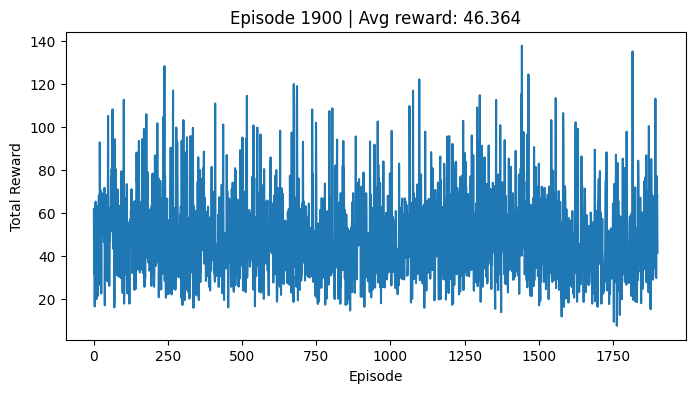

✅ Training complete!


In [ ]:
rewards_history = []
frames = []

for episode in range(max_episodes):
    state = env.reset().flatten() / 2048.0
    total_reward = 0
    done = False

    while not done:
        if np.random.rand() < epsilon:
            action = np.random.randint(4)
        else:
            with torch.no_grad():
                q_values = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))
                action = q_values.argmax().item()

        next_state, reward, done, _ = env.step(action)
        next_state = next_state.flatten() / 2048.0
        reward = np.clip(reward, -1, 1)

        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if len(buffer) > batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            states, next_states = states.to(device), next_states.to(device)
            actions, rewards, dones = actions.to(device), rewards.to(device), dones.to(device)

            q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                max_next_q = target_net(next_states).max(1)[0]
                target_q = rewards + (1 - dones) * gamma * max_next_q

            loss = nn.functional.mse_loss(q_values, target_q)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    rewards_history.append(total_reward)
    frames.append(env.board.copy())

    if episode % update_target == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode % 100 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(8,4))
        plt.title(f"Episode {episode} | Avg reward: {np.mean(rewards_history[-100:]):.3f}")
        plt.plot(rewards_history)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.show()

print("✅ Training complete!")

# Record as Video

In [ ]:
# Convert 2048 board frames to RGB arrays
def board_to_image(board):
    img = np.zeros((400, 400, 3), dtype=np.uint8)
    tile_size = 100
    for y in range(4):
        for x in range(4):
            val = board[y, x]
            color = int(255 - np.log2(val + 1) * 20) if val > 0 else 255
            color = max(0, color)
            img[y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size] = (color, color, color)
    return img

clip_frames = [board_to_image(frame) for frame in frames[::max(len(frames)//300,1)]]
clip = ImageSequenceClip(clip_frames, fps=30)
clip.write_videofile("training.mp4", codec="libx264", verbose=False, logger=None)

HTML("""
<video width="400" height="400" controls>
  <source src="training.mp4" type="video/mp4">
</video>
""")

# Evaluate Agent

In [ ]:
state = env.reset().flatten() / 2048.0
done = False
total_reward = 0

print("🎮 Evaluating trained agent...\n")

while not done:
    with torch.no_grad():
        q_values = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))
        action = q_values.argmax().item()
    next_state, reward, done, _ = env.step(action)
    state = next_state.flatten() / 2048.0
    total_reward += reward
    print(env.board, "\n")

print(f"✅ Evaluation complete! Total reward: {total_reward:.3f}")

Streaming output truncated to the last 5000 lines.
[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2]
 [0 0 0 0]
 [0 0 2 4]
 [2 8 2 8]] 

[[0 0 0 2